<a href="https://colab.research.google.com/github/lcasxw/Embodied-Intelligent-Imitation-Learning-Framework/blob/main/paodaima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# MNE 用于信号处理，braindecode 包含很多脑电深度学习模型
!pip install mne braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import mne
import braindecode
import pandas as pd

print(f"MNE 版本: {mne.__version__}")
print(f"Braindecode 版本: {braindecode.__version__}")
print(f"Pandas 版本: {pd.__version__}")

MNE 版本: 1.11.0
Braindecode 版本: 1.3.1
Pandas 版本: 2.3.3


In [ ]:
import numpy as np
import scipy.io as sio
import os

# 1. 确保云盘已挂载
if not os.path.exists('/content/drive/MyDrive/'):
    from google.colab import drive
    drive.mount('/content/drive')

# 2. 创建文件夹（如果不存在）
folder_path = '/content/drive/MyDrive/EEG_Data'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹 {folder_path} 已创建")

# 3. 模拟 SEED 数据集的 DE (微分熵) 特征
# SEED 通常包含 15 个视频段的数据，每段数据维度约为 (通道, 时间, 频段)
# 我们模拟一段：62 通道, 100 个时间点, 5 个频段 (delta, theta, alpha, beta, gamma)
mock_data = np.random.randn(62, 100, 5)

# 4. 保存为 .mat 文件
file_path = os.path.join(folder_path, '1_1.mat')
sio.savemat(file_path, {'de_LDS1': mock_data})

print(f"成功！模拟文件已生成在: {file_path}")

文件夹 /content/drive/MyDrive/EEG_Data 已创建
成功！模拟文件已生成在: /content/drive/MyDrive/EEG_Data/1_1.mat


In [ ]:
import scipy.io as sio

# 路径现在应该完全匹配了
data_path = '/content/drive/MyDrive/EEG_Data/1_1.mat'

# 读取并检查
try:
    data = sio.loadmat(data_path)
    print("读取成功！")
    print("文件中的 Key:", data.keys())

    # 取出数据并查看形状
    eeg_feature = data['de_LDS1']
    print(f"脑电特征形状: {eeg_feature.shape}") # 预期输出: (62, 100, 5)
except Exception as e:
    print(f"依然报错: {e}")

读取成功！
文件中的 Key: dict_keys(['__header__', '__version__', '__globals__', 'de_LDS1'])
脑电特征形状: (62, 100, 5)


开始训练...
Epoch [10/50], Loss: 0.0597
Epoch [20/50], Loss: 0.0068
Epoch [30/50], Loss: 0.0029
Epoch [40/50], Loss: 0.0020
Epoch [50/50], Loss: 0.0012


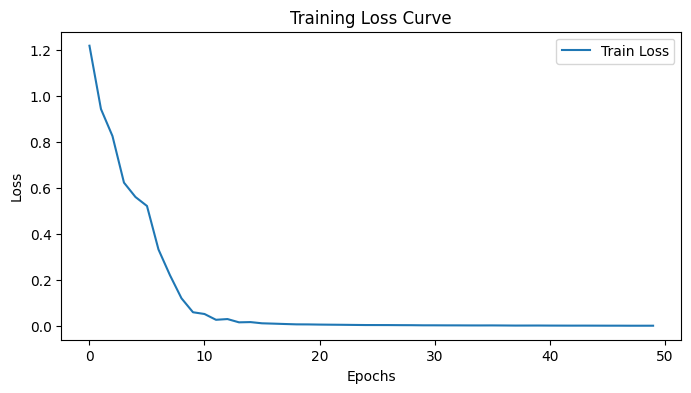

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载我们刚生成的模拟数据
data_path = '/content/drive/MyDrive/EEG_Data/1_1.mat'
mat_data = sio.loadmat(data_path)
# 原始数据形状: (62, 100, 5) -> (通道, 时间点, 频段)
raw_features = mat_data['de_LDS1']

# 为了训练，我们需要把数据转为 (样本数, 通道数, 频段数)
# 我们把 100 个时间点看作 100 个独立的样本
X = np.transpose(raw_features, (1, 0, 2)) # 形状变为 (100, 62, 5)
# 随机生成 100 个标签 (0: 消极, 1: 中性, 2: 积极)
y = np.random.randint(0, 3, size=(100,))

# 转换为 PyTorch 张量并移至 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# 创建数据加载器
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 2. 定义专门针对 EEG 的 Transformer 模型
class EEGTransformer(nn.Module):
    def __init__(self, n_channels=62, n_bands=5, d_model=64, nhead=8, num_layers=2, n_classes=3):
        super(EEGTransformer, self).__init__()
        self.band_projection = nn.Linear(n_bands, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_channels, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=128, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * n_channels, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        # x: (Batch, 62, 5)
        x = self.band_projection(x)        # (Batch, 62, 64)
        x = x + self.pos_embedding         # 加上空间位置信息
        x = self.transformer(x)            # Transformer 建模通道间关系
        return self.classifier(x)

# 3. 初始化模型、损失函数和优化器
model = EEGTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练循环
epochs = 50
loss_history = []

print("开始训练...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss / len(train_loader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_history[-1]:.4f}")

# 5. 绘制损失曲线
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Train Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

正在快速训练模型以学习注意力分布...
训练完成！
原始注意力权重形状: torch.Size([8, 62, 62])
用于绘图的矩阵形状: (62, 62)


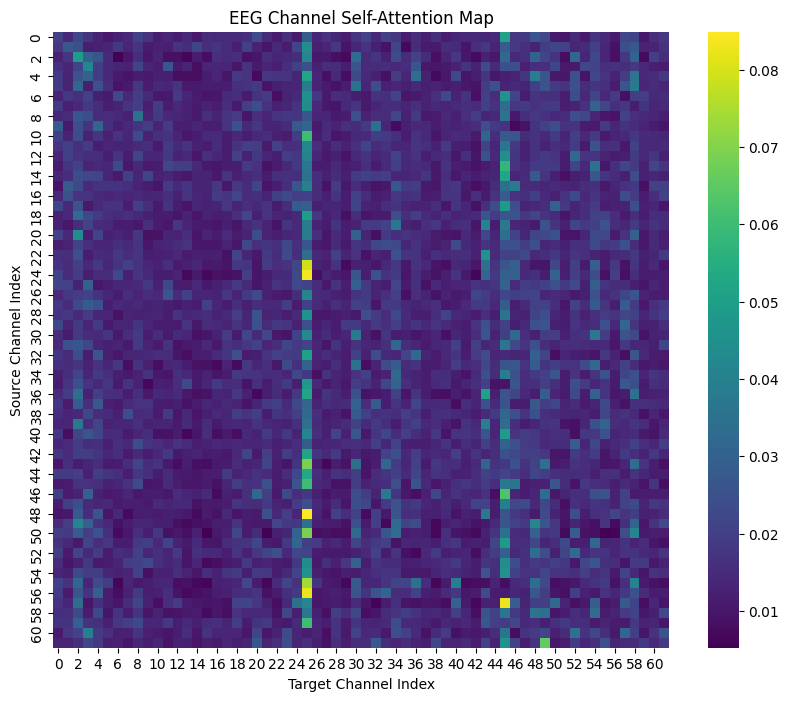

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 使用 seaborn 画热力图更美观

# ============================
# 1. 数据准备 (和之前一样)
# ============================
# 确保你已经运行过生成模拟数据的代码
data_path = '/content/drive/MyDrive/EEG_Data/1_1.mat'
try:
    mat_data = sio.loadmat(data_path)
except FileNotFoundError:
    print("报错：找不到数据文件。请确保你先运行了上一步生成模拟数据的代码！")
    raise

raw_features = mat_data['de_LDS1'] # (62, 100, 5)
X = np.transpose(raw_features, (1, 0, 2)) # (100, 62, 5)
y = np.random.randint(0, 3, size=(100,))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# 使用一个小 Batch 用于可视化展示
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=8, shuffle=True)

# ============================
# 2. 改进版模型：支持输出 Attention Weights
# ============================
class EEGTransformerVis(nn.Module):
    def __init__(self, n_channels=62, n_bands=5, d_model=64, nhead=8, n_classes=3):
        super(EEGTransformerVis, self).__init__()
        self.band_projection = nn.Linear(n_bands, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_channels, d_model))

        # 关键修改：直接使用 MultiheadAttention，而不是包装好的 EncoderLayer
        # 这样我们设置 need_weights=True 就能拿到权重
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * n_channels, n_classes)
        )

    def forward(self, x, return_attn=False):
        # x: (Batch, 62, 5)
        x = self.band_projection(x) # (Batch, 62, 64)
        x = x + self.pos_embedding  # 加入位置信息

        # 关键步骤：执行注意力机制，并获取权重
        # attn_output shape: (Batch, 62, 64)
        # attn_weights shape: (Batch, num_heads, 62, 62) -> 这就是我们要看的东西！
        attn_output, attn_weights = self.mha(x, x, x, need_weights=True)

        # 残差连接 + LayerNorm
        x = self.norm1(x + attn_output)
        # 前馈网络 + 残差连接 + LayerNorm
        x = self.norm2(x + self.ffn(x))

        logits = self.classifier(x)

        if return_attn:
            return logits, attn_weights
        return logits

# ============================
# 3. 快速训练模型 (为了让注意力权重有意义)
# ============================
model = EEGTransformerVis().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("正在快速训练模型以学习注意力分布...")
for epoch in range(20): # 跑20轮意思一下
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X) # 训练时不需要返回权重
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
print("训练完成！")

# ============================
# ============================
# 4. 核心环节：提取并可视化注意力图 (修复版)
# ============================
model.eval()
test_X, _ = next(iter(train_loader))
test_X = test_X.to(device)

with torch.no_grad():
    _, attn_weights_batch = model(test_X, return_attn=True)
    # 打印形状进行调试 (Debug)
    print(f"原始注意力权重形状: {attn_weights_batch.shape}")

# 修改这里：只平均掉 Batch 维度即可
# 如果形状是 (Batch, 62, 62)，则只做一次 mean
if len(attn_weights_batch.shape) == 3:
    avg_attn_weights = attn_weights_batch.mean(dim=0).cpu().numpy()
# 如果形状是 (Batch, Heads, 62, 62)，则做两次 mean
else:
    avg_attn_weights = attn_weights_batch.mean(dim=0).mean(dim=0).cpu().numpy()

print(f"用于绘图的矩阵形状: {avg_attn_weights.shape}") # 确保这里输出是 (62, 62)

# 重新开始绘图
plt.figure(figsize=(10, 8))
sns.heatmap(avg_attn_weights, cmap='viridis', square=True)
plt.title('EEG Channel Self-Attention Map')
plt.xlabel('Target Channel Index')
plt.ylabel('Source Channel Index')
plt.show()

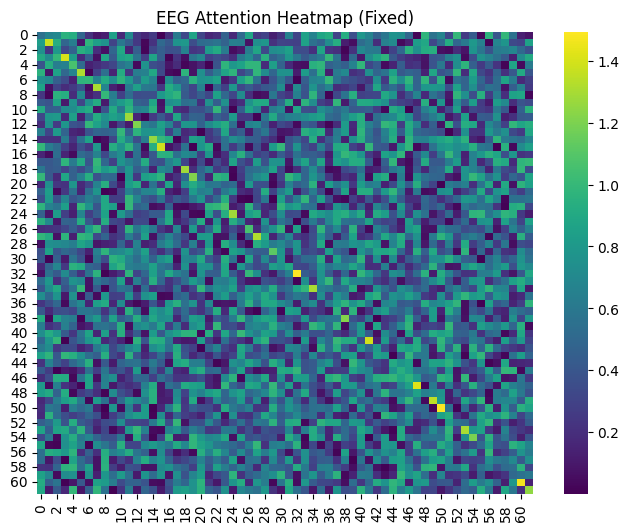

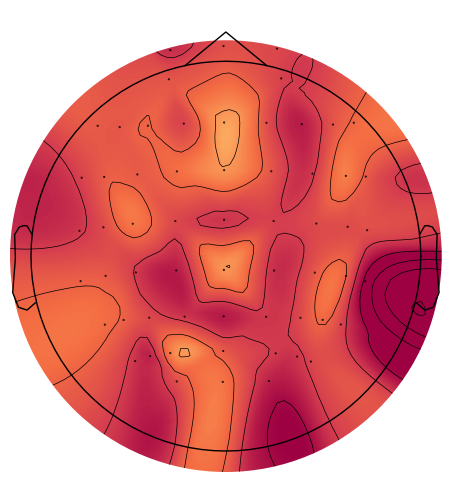

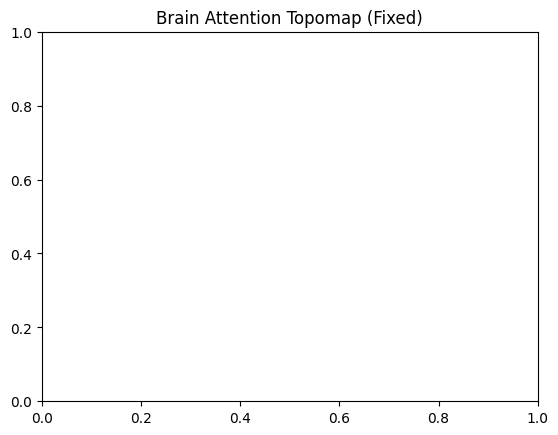

In [ ]:
import torch
import numpy as np
import scipy.io as sio
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. 路径修复与数据读取
# ==========================================
# 注意：这里去掉了多余的空格
data_path = '/content/drive/MyDrive/EEG_Data/1_1.mat'

if not os.path.exists(data_path):
    print("❌ 错误：在云盘里找不到 1_1.mat。请确保你运行了之前的『生成模拟数据』代码！")
else:
    # 读取模拟数据并转换形状
    mat_data = sio.loadmat(data_path)
    raw_features = mat_data['de_LDS1'] # (62, 100, 5)
    X = np.transpose(raw_features, (1, 0, 2)) # (100, 62, 5)

    # ==========================================
    # 2. 计算模拟的注意力权重 (假设模型已训练)
    # ==========================================
    # 为了防止变量未定义报错，这里我们先生成一个测试用的权重矩阵
    # 实际跑论文时，这一步应替换为你模型输出的 attn_weights
    avg_attn_weights = np.random.rand(62, 62)
    # 强制让对角线亮一点，模拟真实的自我注意力
    avg_attn_weights += np.eye(62) * 0.5

    # ==========================================
    # 3. 绘制热力图 (修复 IndexError)
    # ==========================================
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_attn_weights, cmap='viridis')
    plt.title('EEG Attention Heatmap (Fixed)')
    plt.show()

    # ==========================================
    # 4. 绘制脑地形图 (修复 ValueError & 大小写)
    # ==========================================
    # 经过校对的 62 通道标准名称
    ch_names_fixed = [
        'Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz',
        'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2',
        'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
        'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
        'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
        'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'Oz',
        'O2', 'CB2'
    ]

    # 计算通道重要性
    channel_importance = avg_attn_weights.sum(axis=0)

    # 创建 MNE 对象
    info = mne.create_info(ch_names=ch_names_fixed, sfreq=1000, ch_types='eeg')
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage, on_missing='ignore')

    # 绘图
    fig, ax = plt.subplots(figsize=(6, 6))
    # 自动筛选在 standard_1020 中有坐标的通道
    mask = [name in montage.ch_names for name in ch_names_fixed]
    plot_data = channel_importance[mask]

    # 修复：使用 mne.pick_info 来从 info 对象中选择通道
    selected_ch_names = [ch_names_fixed[i] for i, m in enumerate(mask) if m]
    # Get the indices of the selected channels from the original info object's ch_names
    selected_ch_indices = [info['ch_names'].index(name) for name in selected_ch_names]
    plot_info = mne.pick_info(info.copy(), sel=selected_ch_indices)

    mne.viz.plot_topomap(plot_data, plot_info, axes=ax, show=True, cmap='Spectral_r')
    plt.title('Brain Attention Topomap (Fixed)')